<h1>Mapping MHW Events around South Georgia</h1>

**Dataset used here**: Global Ocean OSTIA Sea Surface Temperature and Sea Ice Reprocessed (OSTIA) (Dataset ID: METOFFICE-GLO-SST-L4-REP-OBS-SST)

*Worsfold, M.; Good, S.; Atkinson, C.; Embury, O. Presenting a Long-Term, Reprocessed Dataset of Global Sea Surface Temperature Produced Using the OSTIA System. Remote Sens. 2024, 16, 3358. https://doi.org/10.3390/rs16183358*

Available at: https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/services

In [ ]:
### Imports 

# ! pip install copernicusmarine

import copernicusmarine
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import getpass

import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn
import panel.widgets as pnw
import matplotlib.patches as patches

from IPython.display import IFrame
from datetime import datetime, timedelta
from matplotlib.colors import ListedColormap

copernicusmarine.login()

datasetID = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
DS = copernicusmarine.open_dataset(dataset_id = datasetID)

lon = slice(-44, -30)   
lats = slice(-59, -49)

**Spatial Background Climatology**

In [ ]:
ALL_SG = DS.analysed_sst.sel(longitude = lon, latitude = lats)

filtered = ALL_SG.sel(time=slice('1990-01-01', '2010-12-31'))
filtered = filtered.sel(time=~((filtered['time'].dt.month == 2) & (filtered['time'].dt.day == 29)))

# NON-LEAP YEAR
base_year = 2001                                
doy_index = pd.to_datetime([
    f"{base_year}-{date.month:02d}-{date.day:02d}"
    for date in pd.to_datetime(filtered['time'].values)
])
dayofyear = doy_index.dayofyear

filtered = filtered.assign_coords(dayofyear=("time", dayofyear))

doy_climatology = filtered.groupby('dayofyear').mean(dim='time')

In [ ]:
# Takes 3-5 minutes

doy_climatology_computed = doy_climatology.compute()

**Create dataframe to convert date to integer day of year**

In [5]:
start_date = datetime.strptime("2002-1-01", "%Y-%m-%d")
end_date = datetime.strptime("2002-12-31", "%Y-%m-%d")

date_list = []
date_int = []
current_date = start_date

date_start = 1

while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)
    date_int.append(date_start)
    date_start += 1

dict = {'int': date_int, 'date': date_list}

dates_int = pd.DataFrame.from_dict(dict)

dates_int['month'] = dates_int['date'].dt.month
dates_int['day'] = dates_int['date'].dt.day

**Create list of dates you want to save**

In [33]:
start = datetime(1989, 8, 1)
end = datetime(1989, 12, 31)

list_of_dates = []

while start <= end:
    list_of_dates.append(start.strftime("%Y-%m-%d"))
    start += timedelta(days=14)

print(list_of_dates)

['1989-08-01', '1989-08-15', '1989-08-29', '1989-09-12', '1989-09-26', '1989-10-10', '1989-10-24', '1989-11-07', '1989-11-21', '1989-12-05', '1989-12-19']


**Plotting maps**

In [9]:
# Colour map
reds = ['#FFCAB6', '#FF9975', '#FF6833', '#F6552D', '#ED4126', '#C0321C', '#932211', '#761F11']
custom = ListedColormap(reds)

C:\Users\annas\AppData\Local\Temp\ipykernel_47132\3801652763.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('RdBu')


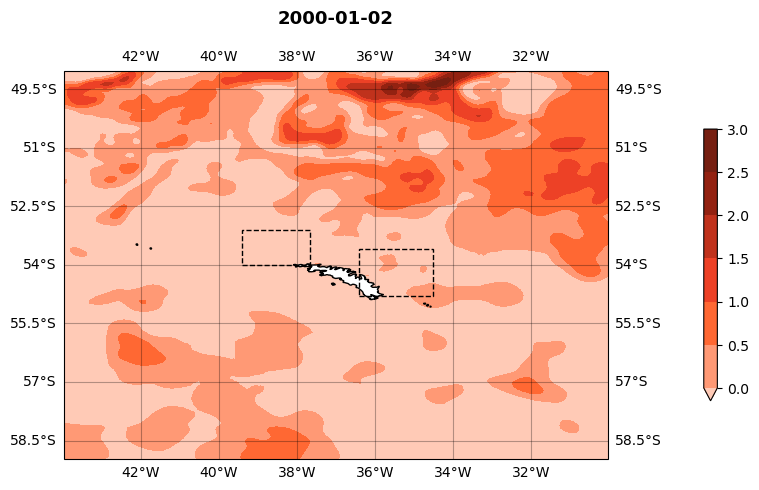

In [ ]:
for d in range(len(list_of_dates)):  
    date = list_of_dates[d]  
    lon = slice(-44, -30)   
    lats = slice(-59, -49) 

    ### FIND DAY INT
    month = datetime.strptime(date, "%Y-%m-%d").month
    day = datetime.strptime(date, "%Y-%m-%d").day
    val = (dates_int.loc[(dates_int['month'] == month) & (dates_int['day'] == day), 'int']).values[0]
    ###

    # Get background climatology map for given day of year (e.g. day 8)
    day_xarray = doy_climatology_computed.isel(dayofyear=int(val))

    # Get raw sst data for given day (e.g. Jan 8th)
    ALL_SG = DS.analysed_sst.sel(longitude = lon, latitude = lats)
    day_act = ALL_SG.sel(time=date)

    # Create xarray of difference 
    diff = day_act - day_xarray

    #### PLOTTING 

    fig = plt.figure(figsize=(10,5))
    crs = ccrs.PlateCarree()
    ax = plt.axes(projection=crs)
    ax.gridlines(crs=crs, color='k', draw_labels=True, alpha=0.3)

    p = diff.plot.contourf(ax=ax, cmap=custom, add_colorbar=False, vmin = 0, vmax = 3)
    p.axes.coastlines(color='k', linewidth=1, zorder=12)
    p.axes.add_feature(cfeature.LAND, facecolor='white', zorder=10)

    # WCB & ECB
    rectangle = patches.Rectangle((-36.4, -54.8), 1.9, 1.2, linewidth=1, edgecolor='k',facecolor='none', zorder=15, linestyle='dashed')
    rectangle2 = patches.Rectangle((-39.4, -54), 1.75, 0.9, linewidth=1, edgecolor='k',facecolor='none', zorder=15, linestyle='dashed')
    plt.gca().add_patch(rectangle)
    plt.gca().add_patch(rectangle2)

    fig.colorbar(p, pad=0.1, shrink=0.7)
    plt.title(f'{date}', fontsize=13, fontweight='bold', y=1.1)
    plt.tight_layout()

    # Save each figure to computer
    plt.savefig(f"YOUR_DIRECTORY/Anom_{date}.jpg")